In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 13.2 MB/s 
     |████████████████████████████████| 7.6 MB 17.4 MB/s 


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence



class Embedding(nn.Module):
    def __init__(self, word_vectors, char_vectors, hidden_size, drop_prob):
        super(Embedding, self).__init__()
        self.drop_prob = drop_prob
        self.w_embed = nn.Embedding.from_pretrained(word_vectors, freeze=True)
        self.c_embed = nn.Embedding.from_pretrained(char_vectors, freeze=False)
        self.proj = nn.Linear(word_vectors.size(1), hidden_size, bias=False)
        self.char_conv = nn.Conv2d(1, 100, (100, 5))
        self.hwy = HighwayEncoder(2, hidden_size * 2)

    def forward(self, x, y):
        batch_size = x.size(0)

        w_emb = self.w_embed(x)  
        w_emb = F.dropout(w_emb, self.drop_prob, self.training)
        w_emb = self.proj(w_emb)

        c_emb = self.c_embed(y)
        c_emb = F.dropout(c_emb, self.drop_prob, self.training)
        c_emb = c_emb.view(-1, 100, c_emb.size(2)).unsqueeze(1)
        c_emb = self.char_conv(c_emb).squeeze()
        c_emb = F.max_pool1d(c_emb, c_emb.size(2)).squeeze()
        c_emb = c_emb.view(batch_size, -1, 100)

        emb = torch.cat([w_emb, c_emb], dim=-1)

        emb = self.hwy(emb)
        return emb


class HighwayEnc(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super(HighwayEnc, self).__init__()
        self.transforms = nn.ModuleList([nn.Linear(hidden_size, hidden_size)
                                         for _ in range(num_layers)])
        self.gates = nn.ModuleList([nn.Linear(hidden_size, hidden_size)
                                    for _ in range(num_layers)])

    def forward(self, x):
        for gate, transform in zip(self.gates, self.transforms):
            g = torch.sigmoid(gate(x))
            t = F.relu(transform(x))
            x = g * t + (1 - g) * x

        return x


class RNNEnc(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers,
                 drop_prob=0.9):
        super(RNNEnc, self).__init__()
        self.drop_prob = drop_prob
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True,
                           bidirectional=True,
                           dropout=drop_prob if num_layers > 1 else 0.)

    def forward(self, x, lengths):
        orig_len = x.size(1)

        lengths, sort_idx = lengths.sort(0, descending=True)
        x = x[sort_idx]     
        x = pack_padded_sequence(x, lengths, batch_first=True)


        x, _ = self.rnn(x)  
        x, _ = pad_packed_sequence(x, batch_first=True, total_length=orig_len)
        _, unsort_idx = sort_idx.sort(0)
        x = x[unsort_idx]  

        x = F.dropout(x, self.drop_prob, self.training)

        return x


class BiDAFAttention(nn.Module):
    def __init__(self, hidden_size, drop_prob=0.1):
        super(BiDAFAttention, self).__init__()
        self.drop_prob = drop_prob
        self.c_weight = nn.Parameter(torch.zeros(hidden_size, 1))
        self.q_weight = nn.Parameter(torch.zeros(hidden_size, 1))
        self.cq_weight = nn.Parameter(torch.zeros(1, 1, hidden_size))
        for weight in (self.c_weight, self.q_weight, self.cq_weight):
            nn.init.xavier_uniform_(weight)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def masked_softmax(logits, mask, dim=-1, log_softmax=False):
        mask = mask.type(torch.float32)
        masked_logits = mask * logits + (1 - mask) * -1e30
        softmax_fn = F.log_softmax if log_softmax else F.softmax
        probs = softmax_fn(masked_logits, dim)

        return probs

    def forward(self, c, q, c_mask, q_mask):
        batch_size, c_len, _ = c.size()
        q_len = q.size(1)
        s = self.get_similarity_matrix(c, q)        
        c_mask = c_mask.view(batch_size, c_len, 1)  
        q_mask = q_mask.view(batch_size, 1, q_len)  
        s1 = masked_softmax(s, q_mask, dim=2)       
        s2 = masked_softmax(s, c_mask, dim=1)       

        
        a = torch.bmm(s1, q)
        b = torch.bmm(torch.bmm(s1, s2.transpose(1, 2)), c)

        x = torch.cat([c, a, c * a, c * b], dim=2)  

        return x

    def get_similarity_matrix(self, c, q):
        c_len, q_len = c.size(1), q.size(1)
        c = F.dropout(c, self.drop_prob, self.training)  
        q = F.dropout(q, self.drop_prob, self.training)  

        s0 = torch.matmul(c, self.c_weight).expand([-1, -1, q_len])
        s1 = torch.matmul(q, self.q_weight).transpose(1, 2).expand([-1, c_len, -1])
        s2 = torch.matmul(c * self.cq_weight, q.transpose(1, 2))
        s = s0 + s1 + s2 + self.bias

        return s
        
    


class BiDAFOutput(nn.Module):
    def __init__(self, hidden_size, drop_prob):
        super(BiDAFOutput, self).__init__()
        self.att_linear_1 = nn.Linear(8 * hidden_size, 1)
        self.mod_linear_1 = nn.Linear(2 * hidden_size, 1)

        self.rnn = RNNEncoder(input_size=2 * hidden_size,
                              hidden_size=hidden_size,
                              num_layers=1,
                              drop_prob=drop_prob)

        self.att_linear_2 = nn.Linear(8 * hidden_size, 1)
        self.mod_linear_2 = nn.Linear(2 * hidden_size, 1)

    def forward(self, att, mod, mask):
        logits_1 = self.att_linear_1(att) + self.mod_linear_1(mod)
        mod_2 = self.rnn(mod, mask.sum(-1))
        logits_2 = self.att_linear_2(att) + self.mod_linear_2(mod_2)

        log_p1 = masked_softmax(logits_1.squeeze(), mask, log_softmax=True)
        log_p2 = masked_softmax(logits_2.squeeze(), mask, log_softmax=True)

        return log_p1, log_p2

In [2]:
import torch
from transformers import AutoTokenizer,BertTokenizerFast

In [3]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

In [4]:
import matplotlib.pyplot as plt 

In [6]:
path = Path('squad/train-v2.0.json')
with open(path, 'rb') as f:
    squad_dict = json.load(f)
texts = []
queries = []
answers = []
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                texts.append(context)
                queries.append(question)
                answers.append(answer)
train_texts, train_queries, train_answers = texts, queries, answers   

In [7]:
path = Path('squad/dev-v2.0.json')
with open(path, 'rb') as f:
    squad_dict = json.load(f)
texts = []
queries = []
answers = []
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                texts.append(context)
                queries.append(question)
                answers.append(answer)
val_texts, val_queries, val_answers = texts, queries, answers

In [15]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2    

In [16]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2   

In [17]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
     

0
0


In [20]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [21]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [24]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
optim = AdamW(model.parameters(), lr=5e-5)
epochs = 3

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [25]:
whole_train_eval_time = time.time()
train_losses = []
val_losses = []
print_every = 1000
for epoch in range(epochs):
  epoch_time = time.time()
  model.train()  
  loss_of_epoch = 0
  print("############Train############")
  for batch_idx,batch in enumerate(train_loader):    
    optim.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    loss.backward()
    optim.step()
    loss_of_epoch += loss.item()
    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")
  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)
  model.eval()
  print("############Evaluate############")
  loss_of_epoch = 0
  for batch_idx,batch in enumerate(val_loader):    
    with torch.no_grad():
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      loss_of_epoch += loss.item()
    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")
  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
############Evaluate############

-------Epoch  1 -------
Training Loss: 5.149744272232056 
Validation Loss: 5.0233354568481445 
Time:  28.545058488845825 
----------------------- 


############Train############
############Evaluate############

-------Epoch  2 -------
Training Loss: 4.382007122039795 
Validation Loss: 4.801649808883667 
Time:  32.53940200805664 
----------------------- 


############Train############
############Evaluate############

-------Epoch  3 -------
Training Loss: 3.6154959201812744 
Validation Loss: 4.739265441894531 
Time:  29.849465370178223 
----------------------- 


Total training and evaluation time:  90.94582176208496


In [26]:
torch.save(model,"/content/squad/model")

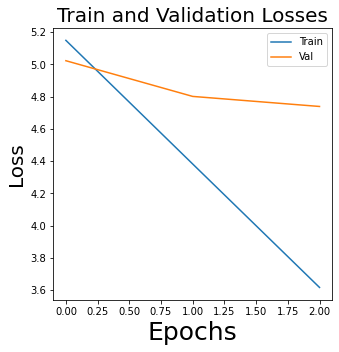

In [27]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

In [28]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = torch.load("/content/squad/model",map_location=torch.device('cpu'))
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [29]:
def predict(context,query):
  inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(outputs[1]) + 1 
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
  return answer
def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re
  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)
  def white_space_fix(text):
    return " ".join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))
def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))
def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split() 
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  if len(common_tokens) == 0:
    return 0 
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  return 2 * (prec * rec) / (prec + rec)

In [30]:
def give_an_answer(context,query,answer):
  prediction = predict(context,query)
  em_score = compute_exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)
  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score}")
  print("\n")

In [31]:

context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano), 
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced 
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly 
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 
True Answer: 1970
EM: 0
F1: 0


Question: Who were the basic members of Queen band?
Prediction: 
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0


Question: What kind of band they are?
Prediction: 
True Answer: rock
EM: 0
F1: 0




In [32]:
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = ["How old is Alexa?",
           "Where does Alexa live now?",
           "Where Alexa used to live?"
          ]
answers = ["21",
           "Kaisariani of Athens",
           "Peristeri of Athens"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)
     


Question: How old is Alexa?
Prediction: 
True Answer: 21
EM: 0
F1: 0


Question: Where does Alexa live now?
Prediction: used to live in peristeri of athens, but now i moved on in kaisariani of athens.
True Answer: Kaisariani of Athens
EM: 0
F1: 0.3157894736842105


Question: Where Alexa used to live?
Prediction: alexa used to live? [SEP] hi! my name is alexa and i am 21 years old. i used to live in peristeri of athens, but now i moved on in kaisariani of athens.
True Answer: Peristeri of Athens
EM: 0
F1: 0.16666666666666669




In [33]:

# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Load the fine-tuned modeol
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.eval()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12,

In [34]:
def predict(context,query):

  inputs = tokenizer.encode_plus(query, context, return_tensors='pt')

  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re

  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()
  
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
  
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return 2 * (prec * rec) / (prec + rec)

In [35]:
def give_an_answer(context,query,answer):

  prediction = predict(context,query)
  em_score = compute_exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)

  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score}")
  print("\n")

In [36]:
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = ["How old is Alexa?",
           "Where does Alexa live now?",
           "Where Alexa used to live?"
          ]
answers = ["21",
           "Kaisariani of Athens",
           "Peristeri of Athens"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: How old is Alexa?
Prediction: 21
True Answer: 21
EM: 1
F1: 1.0


Question: Where does Alexa live now?
Prediction: kaisariani of athens
True Answer: Kaisariani of Athens
EM: 1
F1: 1.0


Question: Where Alexa used to live?
Prediction: peristeri of athens
True Answer: Peristeri of Athens
EM: 1
F1: 1.0




In [42]:
context = " Our narrator, Nick Carraway, moves to the East Coast to work as a bond trader in Manhattan. He rents a small house in West Egg, a nouveau riche town in Long Island. " \
              "In East Egg, the next town over, where old money people live, Nick reconnects with his cousin Daisy Buchanan, her husband Tom, and meets their friend Jordan Baker." \
              "Tom takes Nick to meet his mistress, Myrtle Wilson. Myrtle is married to George Wilson, who runs a gas station in a gross and dirty neighborhood in Queens. Tom, Nick, and Myrtle go to Manhattan, where she hosts a small party that ends with Tom punching her in the face." \
              "Nick meets his next-door neighbor, Jay Gatsby, a very rich man who lives in a giant mansion and throws wildly extravagant parties every weekend, and who is a mysterious person no one knows much about." \
              "Gatsby takes Nick to lunch and introduces him to his business partner - a gangster named Meyer Wolfshiem." \
              "Nick starts a relationship with Jordan. Through her, Nick finds out that Gatsby and Daisy were in love five years ago, and that Gatsby would like to see her again." \
              "Nick arranges for Daisy to come over to his house so that Gatsby can “accidentally” drop by. Daisy and Gatsby start having an affair." \
              "Tom and Daisy come to one of Gatsby’s parties. Daisy is disgusted by the ostentatiously vulgar display of wealth, and Tom immediately sees that Gatsby’s money most likely comes from crime." \
              "We learn that Gatsby was born into a poor farming family as James Gatz. He has always been extremely ambitious, creating the Jay Gatsby persona as a way of transforming himself into a successful self-made man - the ideal of the American Dream."

queries =  ["Who is the narrator?",
                 "Where Gatsby takes Nick?",
                 "With whom Nick starts relationship?",
                 "Where Gatsby was born?"]
answers = ["Nick Carraway",
                 "lunch",
                 "Jordan Baker",
                 "James Gatz"]


for q,a in zip(queries,answers):
  give_an_answer(context,q,a)          


Question: Who is the narrator?
Prediction: nick carraway
True Answer: Nick Carraway
EM: 1
F1: 1.0


Question: Where Gatsby takes Nick?
Prediction: lunch
True Answer: lunch
EM: 1
F1: 1.0


Question: With whom Nick starts relationship?
Prediction: 
True Answer: Jordan Baker
EM: 0
F1: 0


Question: Where Gatsby was born?
Prediction: a poor farming family
True Answer: James Gatz
EM: 0
F1: 0




In [37]:
context = """The Eiffel Tower is a wrought iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887–89 as the entrance to the 1889 World's Fair, it was initially criticized by some of France's leading artists and intellectuals for its design, but it has become a global cultural icon of France and one of the most recognisable structures in the world. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015. The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2"""


queries = ["How tall is the Eiffel Tower?",
           "What is the name of the engineer who designed the Eiffel Tower?",
           "When was the Eiffel Tower built?",
           "What is the name of the company that designed and built the Eiffel Tower?"
           ]
answers = ["324 metres (1,063 ft)",
           "Gustave Eiffel",
           "1887–89",
           "Gustave Eiffel's company"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: How tall is the Eiffel Tower?
Prediction: 324 metres ( 1, 063 ft )
True Answer: 324 metres (1,063 ft)
EM: 0
F1: 0.6666666666666665


Question: What is the name of the engineer who designed the Eiffel Tower?
Prediction: gustave eiffel
True Answer: Gustave Eiffel
EM: 1
F1: 1.0


Question: When was the Eiffel Tower built?
Prediction: 1887 – 89
True Answer: 1887–89
EM: 0
F1: 0


Question: What is the name of the company that designed and built the Eiffel Tower?
Prediction: gustave eiffel
True Answer: Gustave Eiffel's company
EM: 0
F1: 0.4


